In [175]:
from preprocessing.DataList import *
from utility.Solver import *

import torch
import cv2
import matplotlib.pyplot as plt
# Set default figure size
plt.rcParams['figure.figsize'] = (10.0, 10.0)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Extracting the data

In [85]:
# Extract the training data  
labelPath = '/Users/rezaasad/Documents/CMPT742/Project01/data/training_data/LFW_annotation_train.txt'
baseImagePath = '/Users/rezaasad/Documents/CMPT742/Project01/data/lfw'
data = DataList(labelPath, baseImagePath)
# Create a data list
data.MakeList()

We have reached the end of the file


## Visualization of the input
Now let's try to visualize some of the images to make sure they are as expected. Most importantly <br/>
we want to see if the land marks are where they are supposed to be.

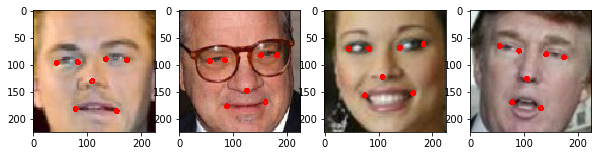

In [99]:
NUM_IMGS = 4
Xsample = data.X[:NUM_IMGS].clone()
ySample = data.y[:NUM_IMGS].clone()

figs, axes = plt.subplots(1, NUM_IMGS)
for i in range(NUM_IMGS):
    # Convert img to array of unit8 type
    img = np.asarray(Xsample[i]).astype('uint8')
    # Move the channel to the last dimension
    img = img.transpose(1, 2, 0)
    img = np.ascontiguousarray(img)
    # Add the landmarks
    landMarks = np.asarray(ySample[i])
    for x,y in landMarks:
        cv2.circle(img, (x,y), 3, 255.0, thickness=3)
    # Plot the image
    axes[i].imshow(img)
plt.show()

## Normalizing the images and land mark coordinates

In [100]:
# I normalize the images to be in range [-1, 1] and the landmarks to 
# be in range [0, 1]
data.ScaleImages()

## Splitting data to train and validation

In [101]:
data.DataSplit()

## Let's save the DataLists that we created in hdf5 format
First I'm going to dump the train and validation data into hdf5

In [184]:
import h5py 

# Make sure the file is not already open
try:
    hdf5.close()
except:
    print("Great, the file is not open")
    
hdf5 = h5py.File('data.h5', 'w')

hdf5.create_dataset('Xtrain', data=data.Xtrain, dtype=np.float32)
hdf5.create_dataset('yTrain', data=data.yTrain, dtype=np.float32)
hdf5.create_dataset('Xval', data=data.Xval, dtype=np.float32)
hdf5.create_dataset('yVal', data=data.yVal, dtype=np.float32)
hdf5.close()

In [201]:
# Now we can load the train and validation datasets.
hdf5 = h5py.File('data.h5', 'r')
Xtrain = torch.from_numpy(np.asarray(hdf5.get('Xtrain')))
yTrain = torch.from_numpy(np.asarray(hdf5.get('yTrain')))
Xval = torch.from_numpy(np.asarray(hdf5.get('Xval')))
yVal = torch.from_numpy(np.asarray(hdf5.get('yVal')))

print("Training data has shape: {}". format(Xtrain.shape))
print("Validation data has shape: {}". format(Xval.shape))
hdf5.close()

Training data has shape: torch.Size([8000, 3, 225, 225])
Validation data has shape: torch.Size([2000, 3, 225, 225])


## Let's feed the data to DataLoader

In [202]:
from preprocessing.DataSet import *
from torch.utils.data import DataLoader

trainDataSet = LFWDataset(Xtrain, yTrain)
valDataSet = LFWDataset(Xval, yVal)
solver = Solver(trainDataSet, valDataSet, batchSize=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The batch has shape: torch.Size([64, 3, 225, 225])
There are 14 land mark coordinates on each face


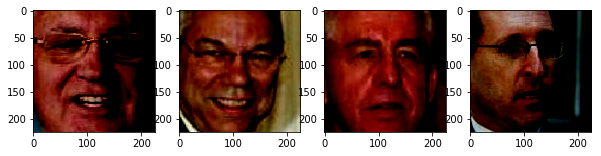

In [203]:
# Now I'm going to read a few data examples from the DataLoader and plot them
idx, (img, landMarks) = next(enumerate(solver.trainLoader))

print("The batch has shape: {}".format(img.shape))
print("There are {} land mark coordinates on each face".format(len(landMarks[0])))

NUM_IMGS = 4
figs, axes = plt.subplots(1, NUM_IMGS)
for i in range(NUM_IMGS):
    axes[i].imshow(np.ascontiguousarray(np.asarray(img[i]).transpose(1, 2, 0)))
plt.show()

## We are now going to use transfer learning to detect land marks.
I'm going to do the following steps:
* Download the pretrained alexnet model.
* Create an instance of my fully connected model (LandMarkAlexNet).
* Set the classifier portion of alexnet to the one I created.

In [105]:
# Downloading the pretrained alexnet
from torchvision import models

alexNet = models.alexnet(pretrained=True)

In [106]:
# First I will freeze the feature parameters for the pretrained alexnet
for param in alexNet.features.parameters():
    param.require_grad = False

# Now I extract the number of input features for the classifier portion of
# the alexnet model
numInFeatures = alexNet.classifier[1].in_features

In [131]:
from models.AlexNetClassifier import * 

# Let's create an instance of my model and set the classifier portion of
# the alexnet to my model.
model = AlexNetClassifier(numInFeatures)
alexNet.classifier = model

In [132]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
solver.train(alexNet, optimizer)

This is epoch 0
Epoch 0, iteration 0 : loss is 0.27


Process Process-111:
Process Process-110:
Process Process-113:
Process Process-114:
Process Process-112:
Process Process-109:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/loc

  File "/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
Exception ignored in: <function _DataLoaderIter.__del__ at 0x1108d7a60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 397, in __del__
    def __del__(self):
  File "/usr/local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 227, in handler
    _error_if_any_worker_fails()
RuntimeError: DataLoader worker (pid 27310) exited unexpectedly with exit code 1. Details are lost due to multiprocessing. Rerunning with num_workers=0 may give better err

KeyboardInterrupt: 